## Only for GDrive

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pwd

%cd /content/drive/My Drive/EVA4/S-15B-Assginment-Solution

/content
/content/drive/My Drive/EVA4/S-15B-Assginment-Solution


## Uncomment for the first run

In [0]:
# !cp /content/drive/My\ Drive/EVA4/S-15-Assignment-Solution/Dataset-15B/Dataset.zip /content

In [0]:
# ! mkdir Dataset
# ! unzip /content/Dataset.zip -d Dataset

## Model Summary

In [0]:
from model import DepthMaskResnetModel,DepthMaskModelV2, DepthMaskModelV6_56x56, DepthMaskModelV5_56x56
from torchsummary import summary
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

mymodel = DepthMaskModelV5_56x56.Model().to(device)
summary(mymodel, input_size=(3, 56, 56))

print("GPU count ",torch.cuda.device_count())


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 56, 56]             864
       BatchNorm2d-2           [-1, 32, 56, 56]              64
              ReLU-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          18,432
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
         Dropout2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]          73,728
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
        Dropout2d-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         294,912
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Dataloader from custom dataset

In [0]:
from Dataloader import get_data_loaders
from albumentationsTransformations import AlbumentationsTransforms

train_transforms = AlbumentationsTransforms(mode='train')
test_transforms = AlbumentationsTransforms(mode='test')
trainloader,testloader = get_data_loaders(100000,110000,295000,300000,train_transforms,test_transforms,32)



Is CUDA available:  True
Hooo Laaa
Input and Label data count  ..........40000
Hooo Laaa
Input and Label data count  ..........20000


### Train and save the model parameters

In [7]:
!pip install pytorch_msssim
from traintest import train, test
import importlib
importlib.reload(train)
import torch.optim as optim
import torch.nn as nn
from utils import load_checkpoint


optimizer = optim.SGD(mymodel.parameters(), lr=0.003, momentum=0.9, weight_decay=0.0005)
start_epoch = 0
############################# Load saved model #################################
file_path = 'Depth_Mask_ModelV5_56_0_400000_v7-colab-transform-final.pt'
mymodel, optimizer, start_epoch, loss = load_checkpoint(mymodel, optimizer, file_path, device)

################################################################################


criterion = nn.BCELoss()
EPOCHS = start_epoch + 3
for epoch in range(start_epoch+1, EPOCHS):  # loop over the dataset multiple times
    print("EPOCH: ", epoch)
    train.train(mymodel, device, trainloader, epoch, optimizer, criterion)
    #Save the model for future use.
    torch.save({'epoch':epoch,
                'model_state_dict': mymodel.state_dict(),
               'optimizer_state_dict': optimizer.state_dict()
              }, 'Depth_Mask_ModelV5_56_0_400000_v10-colab-transform-final.pt')
    test.test(mymodel, device, testloader, criterion)

Finished Training
Finished Training
=> loading checkpoint 'Depth_Mask_ModelV5_56_0_400000_v7-colab-transform-final.pt'


  0%|          | 0/313 [00:00<?, ?it/s]

=> loaded checkpoint 'Depth_Mask_ModelV5_56_0_400000_v7-colab-transform-final.pt' (epoch 9)
EPOCH:  10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Loss=0.1826714277267456 Batch_id=312 Accuracy=79.12: 100%|██████████| 313/313 [09:52<00:00,  1.89s/it]
  0%|          | 0/313 [00:00<?, ?it/s]


Test Set: Average loss: 0.57 , Accuracy: (0.53%)

EPOCH:  11


Loss=0.18569502234458923 Batch_id=312 Accuracy=79.46: 100%|██████████| 313/313 [09:07<00:00,  1.75s/it]



Test Set: Average loss: 0.52 , Accuracy: (0.55%)



## Miscellaneous 

## Display output Images

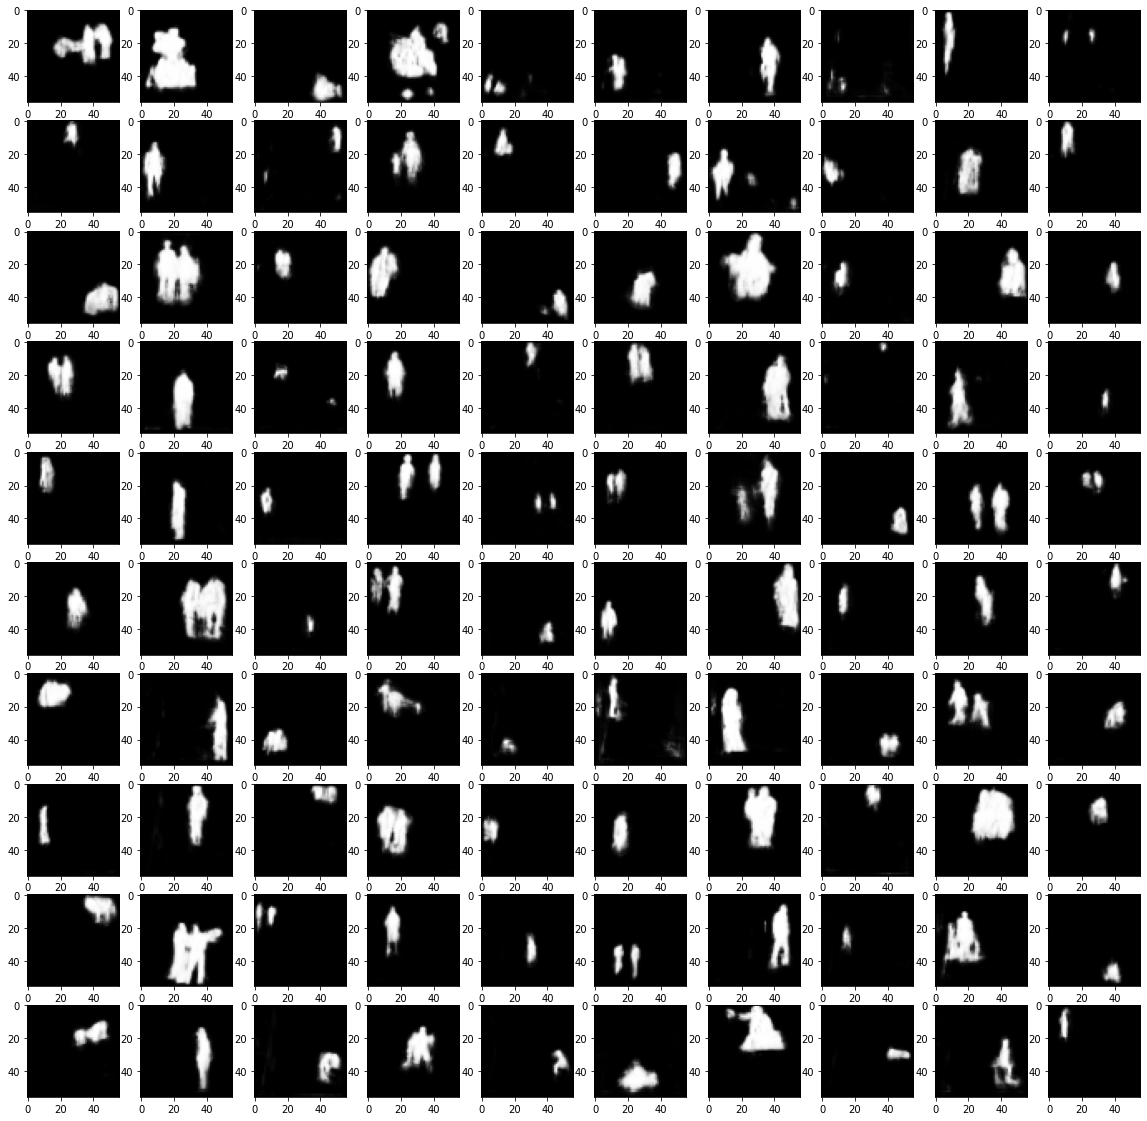

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from itertools import zip_longest

%matplotlib inline
depth_image_list = train.output_images_mask[:-1]

rows = 10
cols = 10
_, axes1 = plt.subplots(rows, cols, figsize=(20, 20))
axes1 = axes1.flatten()


for tnsr,ax in zip_longest(depth_image_list, axes1):
  for i in range(tnsr.shape[0]):
    img = tnsr[i].detach()
    img = transforms.ToPILImage()(img.cpu())
    if ax is not None:
        ax.imshow(img, cmap="gray")
plt.show()

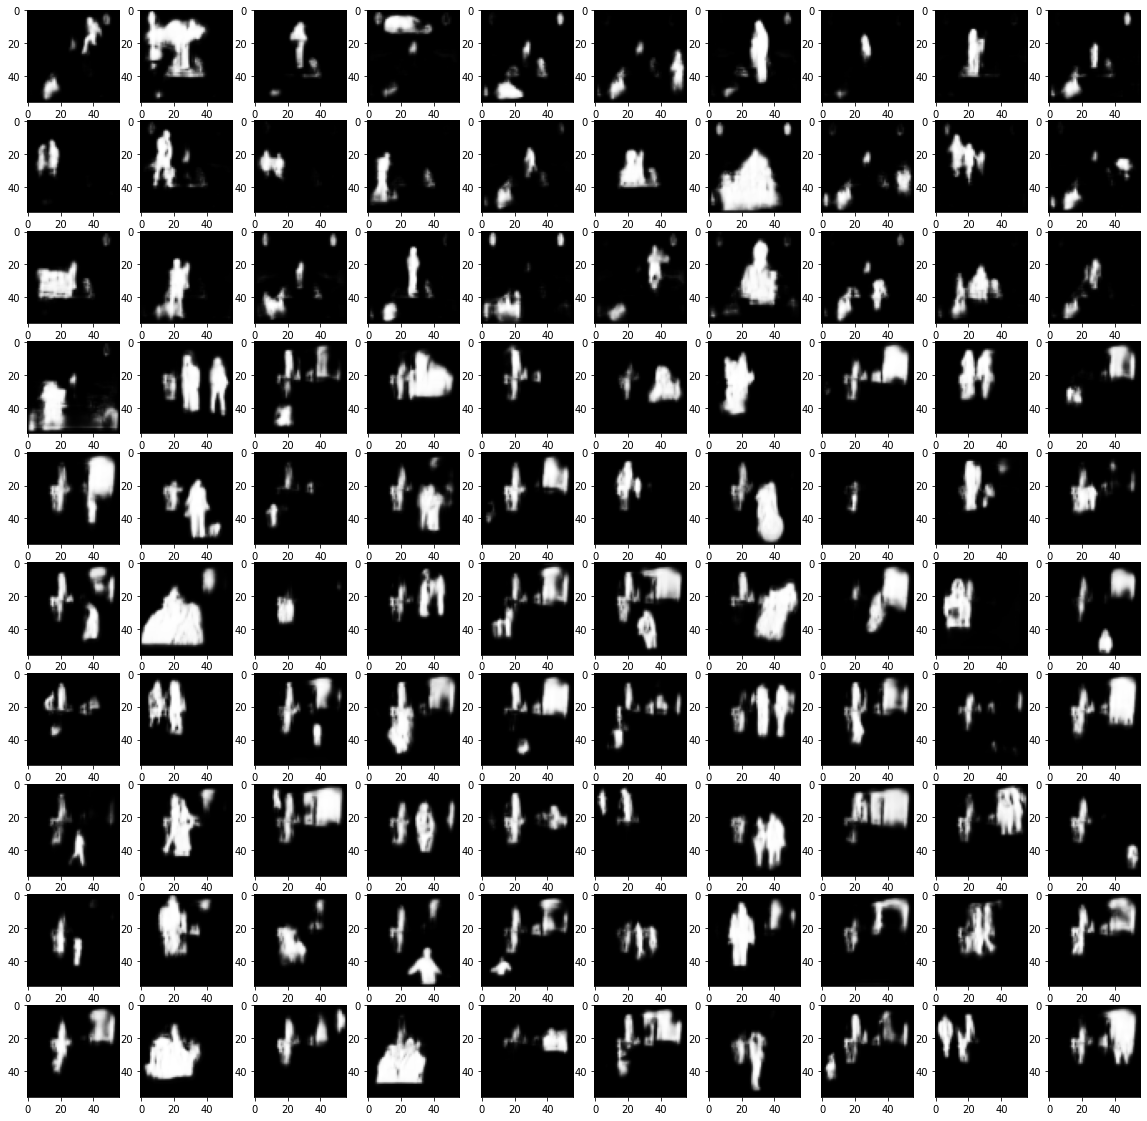

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from itertools import zip_longest

%matplotlib inline
depth_image_list = test.output_images_mask[:-1]

rows = 10
cols = 10
_, axes1 = plt.subplots(rows, cols, figsize=(20, 20))
axes1 = axes1.flatten()


for tnsr,ax in zip_longest(depth_image_list, axes1):
  for i in range(tnsr.shape[0]):
    img = tnsr[i].detach()
    img = transforms.ToPILImage()(img.cpu())
    if ax is not None:
        ax.imshow(img, cmap="gray")
plt.show()

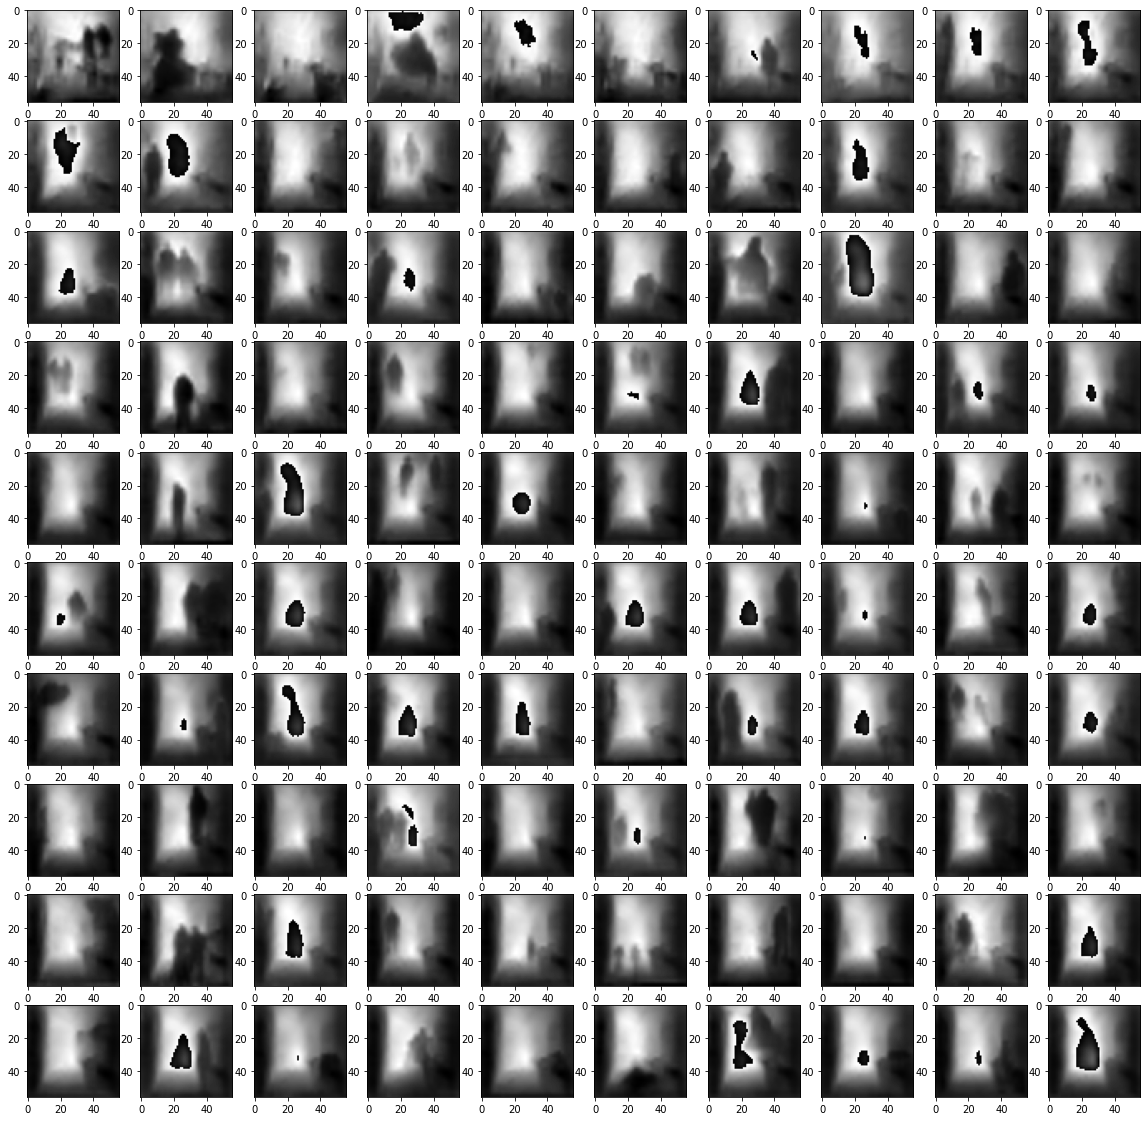

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from itertools import zip_longest

%matplotlib inline
depth_image_list = train.output_images_depth[:-1]

rows = 10
cols = 10
_, axes1 = plt.subplots(rows, cols, figsize=(20, 20))
axes1 = axes1.flatten()


for tnsr,ax in zip_longest(depth_image_list, axes1):
  for i in range(tnsr.shape[0]):
    img = tnsr[i].detach()
    img = transforms.ToPILImage()(img.cpu())
    if ax is not None:
        ax.imshow(img, cmap="gray")
plt.show()

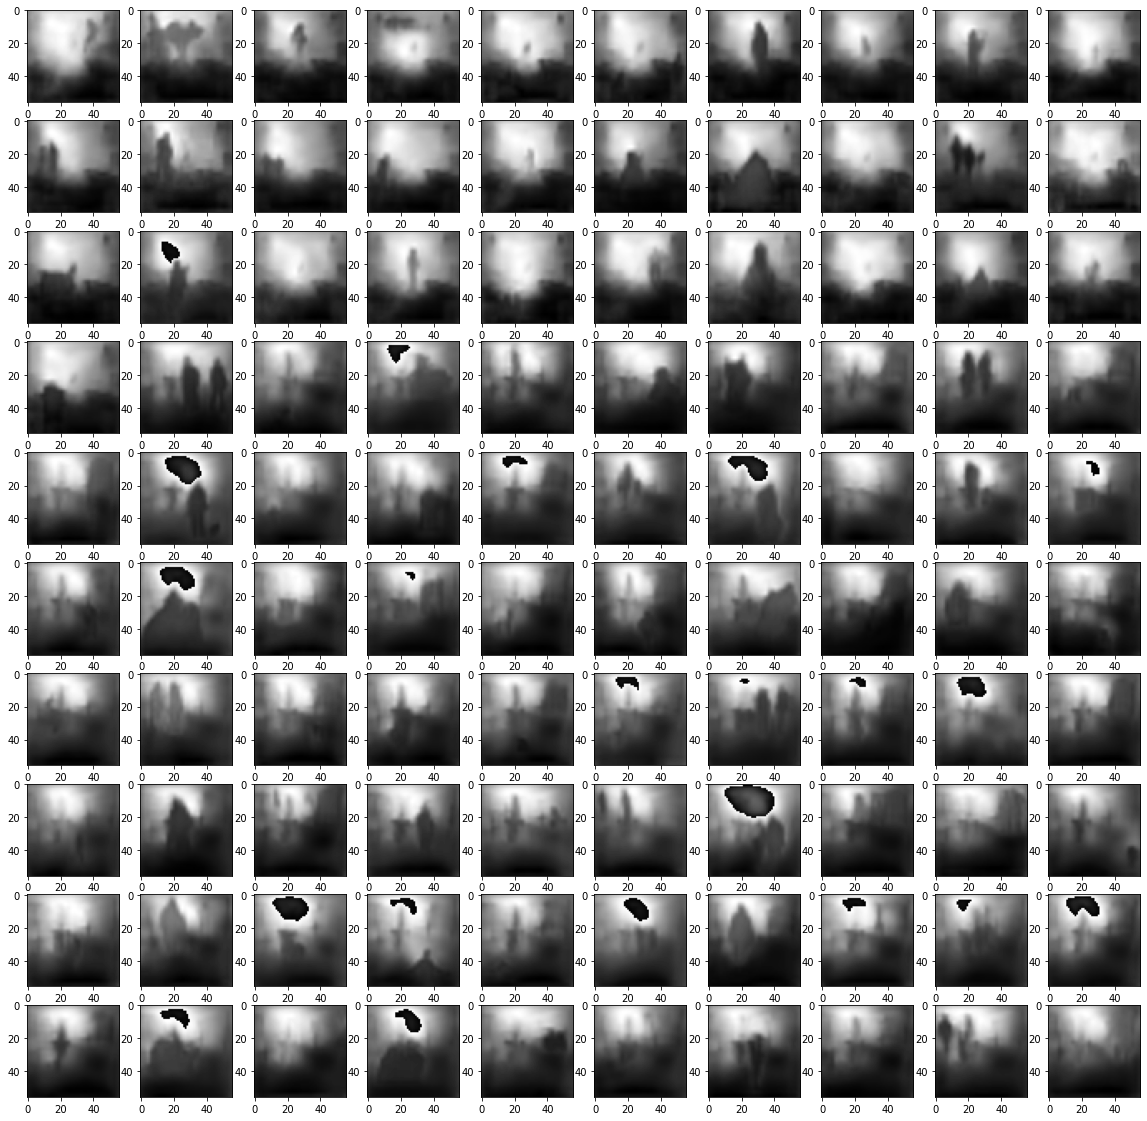

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from itertools import zip_longest

%matplotlib inline
depth_image_list = test.output_images_depth[:-1]

rows = 10
cols = 10
_, axes1 = plt.subplots(rows, cols, figsize=(20, 20))
axes1 = axes1.flatten()


for tnsr,ax in zip_longest(depth_image_list, axes1):
  for i in range(tnsr.shape[0]):
    img = tnsr[i].detach()
    img = transforms.ToPILImage()(img.cpu())
    if ax is not None:
        ax.imshow(img, cmap="gray")
plt.show()

## From Test Images 102647 - 280000 and Train Images 340000 to 400000

In [0]:
# from Dataloader import get_data_loaders
# from albumentationsTransformations import AlbumentationsTransforms

# train_transforms = AlbumentationsTransforms(mode='train')
# test_transforms = AlbumentationsTransforms(mode='test')
# trainloader,testloader = get_data_loaders(0,102645,280000,340000,train_transforms,test_transforms,16)



In [0]:
# !pip install pytorch_msssim
# from traintest import train, test
# import importlib
# importlib.reload(train)
# import torch.optim as optim
# import torch.nn as nn
# from utils import load_checkpoint


# optimizer = optim.SGD(mymodel.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
# start_epoch = 0
# ############################# Load saved model #################################
# file_path = 'Depth_Mask_ModelV5_56_0_400000_v7-colab-transform.pt'
# mymodel, optimizer, start_epoch, loss = load_checkpoint(mymodel, optimizer, file_path, device)

# ################################################################################


# criterion = nn.BCELoss()
# EPOCHS = start_epoch + 2
# for epoch in range(start_epoch+1, EPOCHS):  # loop over the dataset multiple times
#     print("EPOCH: ", epoch)
#     train.train(mymodel, device, trainloader, epoch, optimizer, criterion)
#     #Save the model for future use.
#     torch.save({'epoch':epoch,
#                 'model_state_dict': mymodel.state_dict(),
#                'optimizer_state_dict': optimizer.state_dict()
#               }, 'Depth_Mask_ModelV5_56_102647_400000_v7-local-transform.pt')
#     test.test(mymodel, device, testloader, criterion)

In [0]:
# import matplotlib.pyplot as plt 

# y = train.train_losses
# x = train.train_acc 
# plt.plot(x, y, color='blue') 
# plt.xlabel('Train Acc') 
# plt.ylabel('Train Loss') 
# plt.title('Train Accuracy vs Loss') 
# plt.show()

# y = test.test_losses
# x = test.test_acc 
# plt.plot(x, y, color='red') 
# plt.xlabel('Test Acc') 
# plt.ylabel('Test Loss') 
# plt.title('Test Accuracy vs Loss') 
# plt.show()
